In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

from torchdiffeq import odeint

from pideq.net import PINN

from tqdm.notebook import tqdm

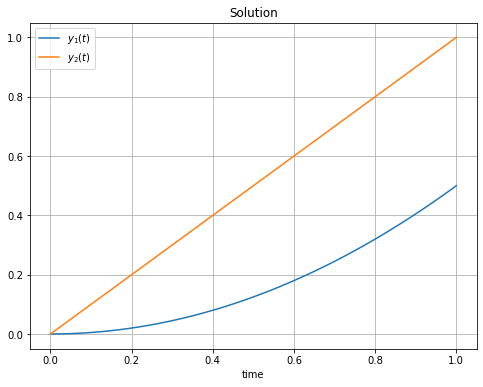

In [4]:
y0 = torch.zeros(1,2)

dt = .01
N = 100
time = torch.Tensor([i * dt for i in range(N+1)])

def newton(y0, C=1, M=1):
    y = torch.zeros_like(y0)

    y[...,0] = y0[...,1]
    y[...,1] = C/M
    
    return y

y = odeint(lambda t, y: newton(y), y0, time, method='rk4')

y_ = y.squeeze().detach().numpy()

time_ = time.numpy()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.set_title('Solution')
ax.plot(time_, y_[:,0], label='$y_1(t)$')
ax.plot(time_, y_[:,1], label='$y_2(t)$')
# ax.set_ylabel('position')
ax.set_xlabel('time')
ax.legend()
ax.grid()

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 21.3 s, sys: 296 ms, total: 21.6 s
Wall time: 1.36 s


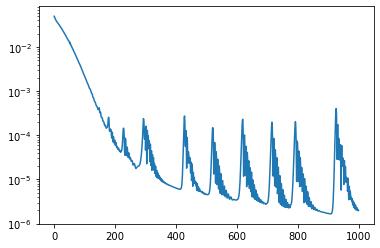

In [5]:
%%time

# training data
t0, y0 = torch.zeros(1,1), y0  # X_b

# model
net = PINN(1., y0=np.array([0.,0.]), n_hidden=2, n_nodes=10)

# loss
loss_fun = nn.MSELoss()

# gradient descent variation
opt = torch.optim.Adam(net.parameters(), lr=1e-1)
# opt = torch.optim.SGD(net.parameters(), lr=2e1)

epochs = 1000
costs = list()
y_preds = list()

X_N = torch.rand(1000,1)
X_N.requires_grad_()

net.train()
for e in tqdm(list(range(epochs))):
    net.train()
    opt.zero_grad()

    y0_pred = net(t0)

    J_b = loss_fun(y0_pred, y0)

    yN_pred = net(X_N)

    dyN = newton(yN_pred)

    dyN_pred1 = torch.autograd.grad(
        yN_pred[:,0].sum(),
        X_N,
        create_graph=True,
    )[0]
    dyN_pred2 = torch.autograd.grad(
        yN_pred[:,1].sum(),
        X_N,
        create_graph=True,
    )[0]
    dyN_pred = torch.stack([dyN_pred1, dyN_pred2], dim=-1).squeeze()

    J_N = loss_fun(dyN_pred-dyN, torch.zeros_like(dyN))

    J = J_b + 0.1 * J_N
    costs.append(J.item())

    J.backward()
    opt.step()

    if e in [9, 99, 999]:
        net.eval()
        y_pred = net(time.unsqueeze(1))

        y_preds.append(y_pred)

plt.plot(costs)
plt.yscale('log')

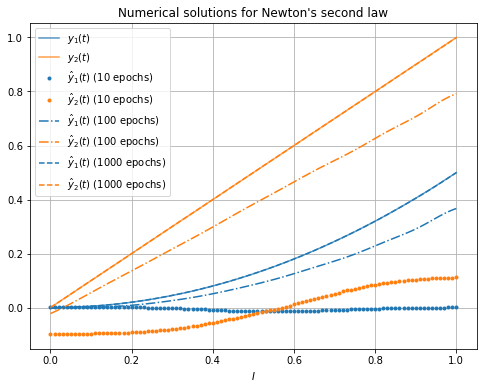

In [6]:
y0 = torch.zeros(1,2)

dt = .01
N = 100
time = torch.Tensor([i * dt for i in range(N+1)])

def newton(y0, C=1, M=1):
    y = torch.zeros_like(y0)

    y[...,0] = y0[...,1]
    y[...,1] = C/M
    
    return y

y = odeint(lambda t, y: newton(y), y0, time, method='rk4')

y_preds_ = [y_pred.squeeze().cpu().detach().numpy() for y_pred in y_preds]
y_ = y.squeeze().detach().numpy()

time_ = time.numpy()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.set_title("Numerical solutions for Newton's second law")
ax.plot(time_, y_[:,0], c='tab:blue', alpha=0.75, label='$y_1(t)$')
ax.plot(time_, y_[:,1], c='tab:orange', alpha=0.75, label='$y_2(t)$')
ax.plot(time_, y_preds_[0][:,0], '.', c='tab:blue', label='$\hat{y}_1(t)$ (10 epochs)')
ax.plot(time_, y_preds_[0][:,1], '.', c='tab:orange', label='$\hat{y}_2(t)$ (10 epochs)')
ax.plot(time_, y_preds_[1][:,0], '-.', c='tab:blue', label='$\hat{y}_1(t)$ (100 epochs)')
ax.plot(time_, y_preds_[1][:,1], '-.', c='tab:orange', label='$\hat{y}_2(t)$ (100 epochs)')
ax.plot(time_, y_preds_[2][:,0], '--', c='tab:blue', label='$\hat{y}_1(t)$ (1000 epochs)')
ax.plot(time_, y_preds_[2][:,1], '--', c='tab:orange', label='$\hat{y}_2(t)$ (1000 epochs)')
# ax.set_ylabel('position')
ax.set_xlabel('$I$')
ax.legend()
ax.grid()

plt.savefig('pinn_newton.pdf')
plt.show()